In [68]:
import json
import time
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx
import requests
from bs4 import BeautifulSoup
from dateutil import parser
from tqdm import tqdm


In [63]:
'''
token - vk api token
my_id - id пользователя, от которого будет выстроен граф
'''

TOKEN = ''
MY_ID = ''
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"}

In [64]:
@dataclass
class User:
    id: int
    is_closed: bool
    first_name: str
    last_name: str
    age: int
    city: str
    friendlist: list = None
    universities: list = None
    schools: list = None
    

In [5]:
'''
расчет расстояния между двумя городами
'''
def calculate_distance_between_cities(city_1, city_2):
    city_1 = city_1.replace(' ', '-')
    city_2 = city_2.replace(' ', '-')
    r = requests.get(f'https://www.distance.to/{city_1}/{city_2}', headers=headers)
    soup = BeautifulSoup(r.text)
    try:
        distance = float(soup.find('span', class_="value km").text.replace(',',''))
        distance = 0 if distance < 20 else distance
        return int(distance)
    except:
        time.sleep(4)

In [8]:
'''
получение списка друзей пользователя по id
'''
def get_friends(id):
    try:
        response = requests.get(f'https://api.vk.com/method/friends.get?user_id={id}&v=5.131&access_token={TOKEN}')
    except:
        time.sleep(4)
    return json.loads(response.text)['response']['items']


In [9]:
'''
перевод даты рождения в возраст
'''
def calc_age(bdate):
    return int((datetime.now() - parser.parse(bdate)).days / 365.2425)

In [65]:
'''
получение данных пользователя по id
'''
def get_user_by_id(id):
    response = json.loads(requests.get(f'https://api.vk.com/method/users.get?user_ids={id}&fields=bdate,city,home_town,schools,education,universities&access_token={TOKEN}&v=5.131').text)
    response = response['response'][0]
    if 'home_town' not in response:
        response['home_town'] = None
    if 'deactivated' in response:
        return None
    user = User(response['id'], 
                response['is_closed'],
                response['first_name'], 
                response['last_name'], 
                age=calc_age(response['bdate']) if 'bdate' in response else None,
                city=response['city']['title'] if 'city' in response else response['home_town'],
                schools=response['schools'] if 'schools' in response else [],
                universities=[{'id': response['university']}] if 'university' in response else [])
    if "universities" in response:
        user.universities += response['universities']
    try:
        user.friendlist = get_friends(response['id'])
    except:
        user.friendlist = []
    return user

<h1>Create social graph with nx</h1>


In [11]:
'''
center_user = юзер, чей my_id указывали выше
'''
graph = nx.Graph()
center_user = get_user_by_id(MY_ID)
users = {center_user.last_name: center_user}

In [12]:
'''
создаем вершины - друзья center_user,
также добавляем вершины для тех юзеров, кто дружат с center_user и с кем-то из center_user.friendlist
'''
for friend_id in tqdm(center_user.friendlist):
    graph.add_node(friend_id)
    graph.add_edge(center_user.id, friend_id)
    try:
        friend = get_user_by_id(friend_id)
    except:
        friend = None
        time.sleep(4)
    if friend:
        users[friend.id] = friend
    if friend is None or friend.is_closed:
        continue
    for friend_id in friend.friendlist:
        if friend_id in center_user.friendlist:
            graph.add_node(friend_id)
            graph.add_edge(friend.id, friend_id)
    time.sleep(1)

100%|██████████| 257/257 [04:35<00:00,  1.07s/it]


In [13]:

for user_id in center_user.friendlist:
    if user_id not in users:
        center_user.friendlist.remove(user_id)

<h1>Социальный граф (в центре center_user)</h1>

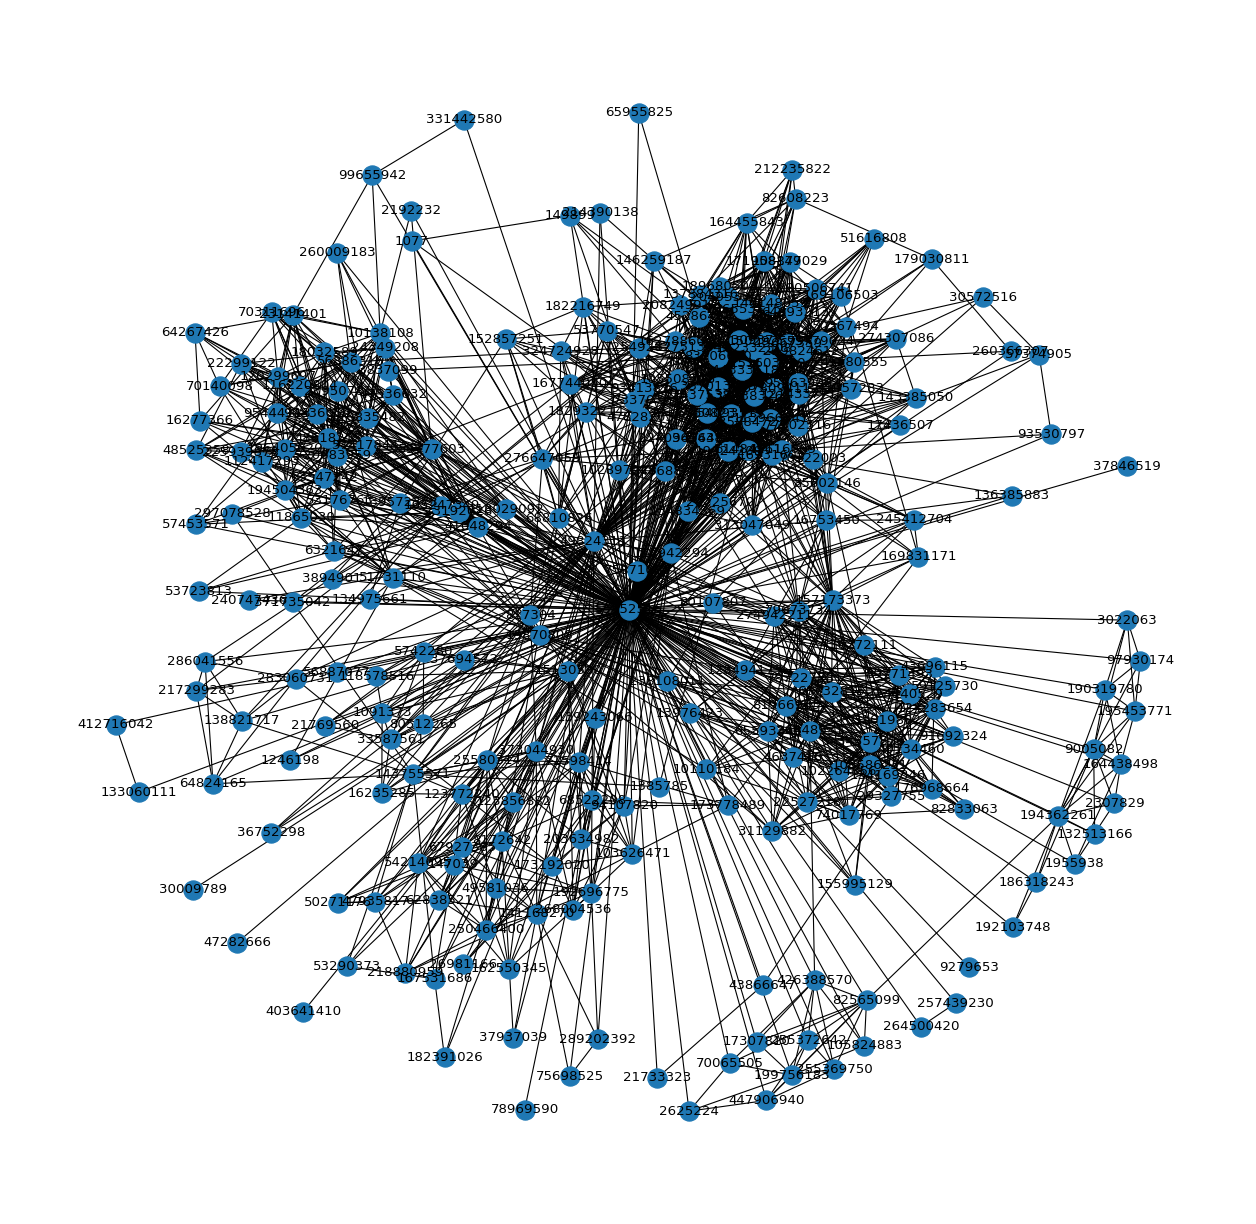

In [66]:
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(graph)
nx.draw(graph,pos, with_labels=True)

<h1>Матрица смежности</h1>

In [73]:
adj_matrix = nx.adjacency_matrix(graph, nodelist=center_user.friendlist)
df = nx.to_pandas_adjacency(graph)
df


C:\Users\Xiaomi\AppData\Local\Temp/ipykernel_5456/3808416145.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(graph, nodelist=center_user.friendlist)


,1077,53852516,73370,149899,11437538,17436507,24868858,25580314,29725670,47828203,...,289202392,371735042,260366307,297078528,186318243,192103748,257439230,264500420,331442580,403641410
1077,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53852516,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
73370,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149899,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11437538,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192103748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
257439230,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
264500420,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
331442580,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1>Сетевая закрытость</h1>
Степень, в которой друзья пользователя являются друзьями друг другу.
\[NC = \frac{n}{N}\], где $n$ - число ребер, в которых вершины - 2 разных друга пользователя <br>
$N$ - общее число друзей пользователя

In [41]:
'''
количество "дружб" разных пользователей, (сумма единиц в
каждом столбце, не учитывая ценрального юзера)
'''
n = sum([int(df[friend_id].sum()-1) for friend_id in center_user.friendlist])

In [42]:
n

1675

In [43]:
n / (len(center_user.friendlist))

11.092715231788079

<h1> Множественность </h1>
Число множественных связей, образуемых пользователями (школа+вуз)

In [47]:
g = nx.Graph() 

In [48]:
g.add_node(center_user.id)
center_user_univs = set(center_user.universities)
center_user_schools = set(center_user.schools)
for friend in list(users.values())[1:]:
    friend_univs = set(friend.universities)
    friend_schools = set(friend.schools)
    if center_user_univs & friend_univs and center_user_schools & friend_schools:
        g.add_node(friend.id)
        g.add_edge(center_user.id, friend.id)

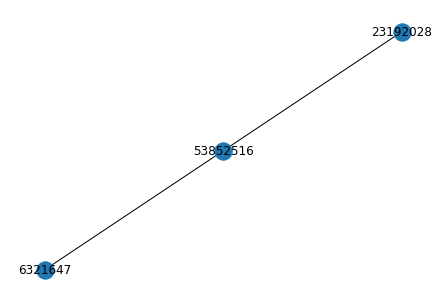

In [49]:
nx.draw(g, with_labels=True)

<h1>Взаимность</h1>
Cтепень, с которой пользователи отвечают взаимностью на действия друг друга

In [52]:

def get_user_photos(id):
    response = requests.get(f'https://api.vk.com/method/photos.getAll?count=20&owner_id={id}&v=5.131&access_token={TOKEN}')
    if 'error' in response.text:
        return []
    jsonify_items = json.loads(response.text)['response']['items']
    return [item['id'] for item in jsonify_items]



In [53]:
for user in tqdm(users.values()):
    user.photos = get_user_photos(user.id)
    time.sleep(1)

100%|██████████| 256/256 [05:34<00:00,  1.31s/it]


In [54]:
def is_liked(user_id, owner_id, photo_id):
    repeat = True
    while repeat:
        response = requests.get(f'https://api.vk.com/method/likes.isLiked?type=photo&user_id={user_id}&owner_id={owner_id}&item_id={photo_id}&v=5.131&access_token={TOKEN}')
        if 'error' in response.text:
            if 'private' in response.text:
                return False
            time.sleep(0.4)
        else:
            repeat = False
            return bool(json.loads(response.text)['response']['liked'])

In [55]:
G = nx.Graph()
G.add_node(center_user.id)

likes_to_friends = {}

In [ ]:
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G, k=5)  # For better example looking
nx.draw(G, pos, with_labels=True)
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [ ]:
for friend in tqdm(list(users.values())[1:]):
    for photo_id in tqdm(center_user.photos):
    
        if is_liked(friend.id, center_user.id, photo_id):
            if not G.has_node(friend.id):
                G.add_node(friend.id)
            if G.has_edge(center_user.id, friend.id):
                G[center_user.id][friend.id]["weight"] -= 1


In [ ]:
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G, k=5)  # For better example looking
nx.draw(G, pos, with_labels=True)
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [76]:
center_user.photos

[457245265,
 457244369,
 457243977,
 456243063,
 456242706,
 456242445,
 456242408,
 456242209,
 456242011,
 456241878,
 456241877,
 456241659,
 456241633,
 456241628,
 456241616,
 456241513,
 456241462,
 456241333,
 456241142,
 456240923]

In [75]:
likes_from_friends = {}  # friend_id: likes_count

for friend in tqdm(list(users.values())[1:]):
    for photo_id in center_user.photos:
        if is_liked(friend.id, center_user.id, photo_id):
            if friend.id in likes_from_friends:
                likes_from_friends[friend.id] += 1
            else:
                likes_from_friends.update({friend.id: 1})

100%|██████████| 255/255 [28:44<00:00,  6.76s/it]


In [77]:
likes_from_friends

{817304: 3,
 2307829: 1,
 5550823: 1,
 5742280: 3,
 6321647: 1,
 8172642: 3,
 9005082: 1,
 11437538: 3,
 13976423: 4,
 15130580: 2,
 15667359: 2,
 16235285: 2,
 16272111: 7,
 16277366: 2,
 16753450: 1,
 16931602: 6,
 17307810: 2,
 19870808: 2,
 20683959: 1,
 21769560: 1,
 22299122: 4,
 22527218: 1,
 23192028: 10,
 24349208: 2,
 29230937: 9,
 29327755: 8,
 30009789: 2,
 31129882: 1,
 33587561: 1,
 34357858: 8,
 35884723: 1,
 36543809: 1,
 36752298: 1,
 37694572: 8,
 40134460: 3,
 41580555: 1,
 43866647: 8,
 45286474: 2,
 47282666: 1,
 47828203: 1,
 47935817: 1,
 48518215: 5,
 48525358: 4,
 49824311: 7,
 50367494: 2,
 53176763: 1,
 53723813: 1,
 54093513: 4,
 54140529: 1,
 56886316: 7,
 59125730: 1,
 59377603: 1,
 61484161: 4,
 62838521: 2,
 63547242: 1,
 64824165: 1,
 66732815: 1,
 67927385: 7,
 68522208: 1,
 70065505: 1,
 70122003: 2,
 71057283: 3,
 71598414: 2,
 72549262: 1,
 75698525: 1,
 75779024: 2,
 75871088: 3,
 78722778: 2,
 80107807: 14,
 80512265: 4,
 81966963: 3,
 82565099: 6

In [78]:
likes_graph = nx.Graph()

likes_graph.add_node(center_user.id)

for friend_id in likes_to_friends:
    likes_graph.add_node(friend_id)
    likes_graph.add_edge(center_user.id, friend_id, weight=likes_to_friends[friend_id])

In [79]:
for friend_id in likes_from_friends:
    if not likes_graph.has_node(friend_id):
        likes_graph.add_node(friend_id)
        likes_graph.add_edge(center_user.id, friend_id, weight=0)
    else:
        likes_graph[center_user.id][friend_id]['weight'] /= likes_from_friends[friend_id]

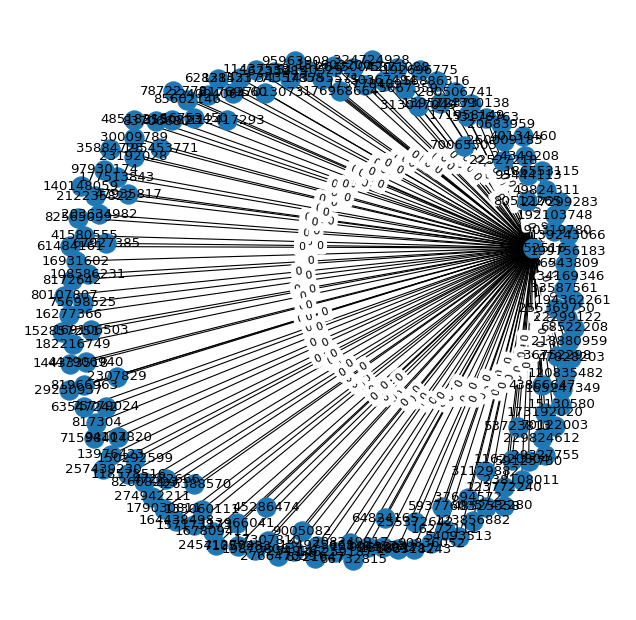

<Figure size 432x288 with 0 Axes>

In [85]:
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(likes_graph, k=4.2)  # For better example looking
nx.draw(likes_graph, pos, with_labels=True)
labels = {e: likes_graph.edges[e]['weight'] for e in likes_graph.edges}
nx.draw_networkx_edge_labels(likes_graph, pos, edge_labels=labels)
plt.show()


plt.savefig('vzaimnost.png')
